## 实验：MNIST 优化算法对比

### 实验概要

在之前的实验中，我们主要对各种梯度下降优化算法的数学逻辑进行讲解，并绘制其梯度下降轨迹图；在本实验中，我们将进一步把它们放到同一个数据集与神经网络中，在完全相同的『赛道』上，测试各种梯度下降优化算法的性能。

<img src="./img/compare_15.png" width="50%">

### 实验目标

在本实验中，我们通过 TensorFlow 快速的建立一个卷积神经网络，分别使用：SGD，AdaGrad，RMSProp，AdaDelta，Adam 优化器对 MNIST 数据集进行模型训练，测试不同的优化算法在相同的数据集上的准确率对比。

### 1. 导入库

由于通过 Python 实现完整的卷积神经网络需要大量的代码，这里为了简便实现，使用工业标准深度学习框架 TensorFlow 2.x 版本实现，前端 API 为 Keras。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

### 2. 加载数据

MNIST 是 TensorFlow 的内置数据集，直接从框架中导入即可。

```keras.datasets.mnist.load_data()```

但由于需要从互联网上下载，连接可能不稳定，我们直接下载到本地，使用下面的代码进行加载。

与之前实验一样，训练集与测试据依然是 60000 张 / 10000 张 `28*28` 像素图片。

In [2]:
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab15/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

path = data_path+'mnist.npz'

f = np.load(path)
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(60000, 28, 28)   (60000,)
(10000, 28, 28)   (10000,)


### 3. 查看数据

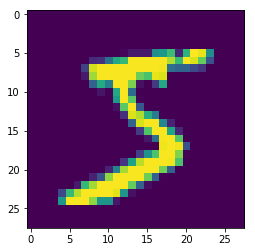

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[0])
plt.show()

### 4. 数据变换

`mnist.load_data()` 为 MNIST 提供的数据结构是（nb_samples，28，28）3 个维度，即每个样本分别具有 2 个维度，表示 `28x28` 的灰度图像。但是，Keras 中的 Convolution2D 图层设计为每个数据样本设计了 3 个维度，即：它们具有 4 维输入和输出。因此，MNIST 输入的灰度图像需要通过 `reshape` 转换为匹配 Keras 图层设计的标准。当 `reshape` 使用 `-1` 时，Numpy 会根据剩下的维度，计算出新数组的 shape 属性值。详细信息请 [查阅官方文档](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)。

In [4]:
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))

输出重塑之后的形状：

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 5. 模型搭建

这里使用贯序模型，一层一层叠加模型：

In [6]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]),
                        filters=32, kernel_size=(3,3), strides=(1,1), padding='valid',
                       activation='relu'))

model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))

# 分类层
model.add(layers.Dense(10, activation='softmax'))

### 6. 配置优化器

我们将在相同的网络下，分别使用：**SGD**，**AdaGrad**，**RMSProp**，**AdaDelta**，**Adam** 优化器进行训练并记录精确度。

#### 6.1 使用 SGD 优化器

In [7]:
model.compile(optimizer=keras.optimizers.SGD(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________


#### 6.2  SGD 优化器训练模型

In [8]:
# 记录训练历史
history_sgd = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 21s 24ms/step - loss: 0.4350 - accuracy: 0.9204 - val_loss: 0.1901 - val_accuracy: 0.9457
Epoch 2/5
844/844 [==============================] - 35s 41ms/step - loss: 0.1100 - accuracy: 0.9655 - val_loss: 0.0892 - val_accuracy: 0.9737
Epoch 3/5
844/844 [==============================] - 38s 45ms/step - loss: 0.0827 - accuracy: 0.9748 - val_loss: 0.1234 - val_accuracy: 0.9680
Epoch 4/5
844/844 [==============================] - 28s 33ms/step - loss: 0.0668 - accuracy: 0.9791 - val_loss: 0.0836 - val_accuracy: 0.9758
Epoch 5/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0561 - accuracy: 0.9823 - val_loss: 0.0825 - val_accuracy: 0.9785


#### 6.3 使用 AdaGrad 优化器

In [9]:
model.compile(optimizer=keras.optimizers.Adagrad(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________


#### 6.4 使用 AdaGrad 优化器训练模型

In [10]:
# 记录训练历史
history_adagrad=model.fit(x_train,y_train,batch_size=64,epochs=5,validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 30s 34ms/step - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.0740 - val_accuracy: 0.9815
Epoch 2/5
844/844 [==============================] - 24s 29ms/step - loss: 0.0237 - accuracy: 0.9936 - val_loss: 0.0740 - val_accuracy: 0.9817
Epoch 3/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0218 - accuracy: 0.9946 - val_loss: 0.0733 - val_accuracy: 0.9817
Epoch 4/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0204 - accuracy: 0.9952 - val_loss: 0.0740 - val_accuracy: 0.9820
Epoch 5/5
844/844 [==============================] - 26s 31ms/step - loss: 0.0194 - accuracy: 0.9956 - val_loss: 0.0743 - val_accuracy: 0.9817


#### 6.5 使用 RMSprop 优化器

In [11]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________


#### 6.6 使用 RMSprop 优化器训练模型

In [12]:
# 记录训练历史
history_rms=model.fit(x_train,y_train,batch_size=64,epochs=5,validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 23s 25ms/step - loss: 0.0708 - accuracy: 0.9787 - val_loss: 0.0837 - val_accuracy: 0.9797
Epoch 2/5
844/844 [==============================] - 26s 31ms/step - loss: 0.0534 - accuracy: 0.9844 - val_loss: 0.0848 - val_accuracy: 0.9790
Epoch 3/5
844/844 [==============================] - 26s 31ms/step - loss: 0.0435 - accuracy: 0.9874 - val_loss: 0.0825 - val_accuracy: 0.9795
Epoch 4/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0343 - accuracy: 0.9902 - val_loss: 0.0915 - val_accuracy: 0.9812
Epoch 5/5
844/844 [==============================] - 25s 29ms/step - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.0948 - val_accuracy: 0.9822


#### 6.7 使用 AdaDelta 优化器

In [13]:
model.compile(optimizer=keras.optimizers.Adadelta(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________


#### 6.8 使用 AdaDelta 优化器训练模型

In [14]:
# 记录训练历史
history_delta=model.fit(x_train,y_train,batch_size=64,epochs=5,validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 27s 30ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0934 - val_accuracy: 0.9823
Epoch 2/5
844/844 [==============================] - 29s 34ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.0922 - val_accuracy: 0.9827
Epoch 3/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0912 - val_accuracy: 0.9828
Epoch 4/5
844/844 [==============================] - 25s 29ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0904 - val_accuracy: 0.9832
Epoch 5/5
844/844 [==============================] - 24s 29ms/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.0896 - val_accuracy: 0.9833


#### 6.9 使用 Adam 优化器

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                173088    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________


#### 6.10 使用 Adam 优化器训练模型

In [16]:
# 记录训练历史
history_adam=model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 28s 32ms/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0981 - val_accuracy: 0.9793
Epoch 2/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.0962 - val_accuracy: 0.9820
Epoch 3/5
844/844 [==============================] - 27s 32ms/step - loss: 0.0164 - accuracy: 0.9944 - val_loss: 0.1080 - val_accuracy: 0.9793
Epoch 4/5
844/844 [==============================] - 26s 31ms/step - loss: 0.0185 - accuracy: 0.9942 - val_loss: 0.1123 - val_accuracy: 0.9795
Epoch 5/5
844/844 [==============================] - 31s 36ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.1276 - val_accuracy: 0.9795


### 7. 不同优化器训练准确率对比

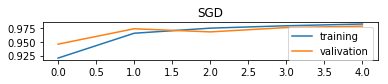

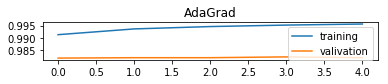

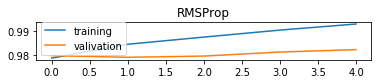

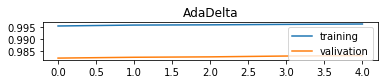

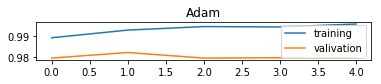

In [17]:
plt.subplot(5,1,1)
plt.plot(history_sgd.history['accuracy'])
plt.plot(history_sgd.history['val_accuracy'])
plt.legend(['training', 'valivation'])
plt.title('SGD')
plt.show()

plt.subplot(5,1,2)
plt.plot(history_adagrad.history['accuracy'])
plt.plot(history_adagrad.history['val_accuracy'])
plt.legend(['training', 'valivation'])
plt.title('AdaGrad')
plt.show()

plt.subplot(5,1,5)
plt.plot(history_rms.history['accuracy'])
plt.plot(history_rms.history['val_accuracy'])
plt.legend(['training', 'valivation'])
plt.title('RMSProp')
plt.show()

plt.subplot(5,1,4)
plt.plot(history_delta.history['accuracy'])
plt.plot(history_delta.history['val_accuracy'])
plt.legend(['training', 'valivation'])
plt.title('AdaDelta')
plt.show()

plt.subplot(5,1,3)
plt.plot(history_adam.history['accuracy'])
plt.plot(history_adam.history['val_accuracy'])
plt.legend(['training', 'valivation'])
plt.title('Adam')
plt.show()

### 实验小结

在本实验中，你实现了通过 TensorFlow 快速的建立一个卷积神经网络，分别使用：SGD，AdaGrad，RMSProp，AdaDelta，Adam 优化器对 MNIST 数据集进行模型训练，并且测试不同的优化算法在相同的数据集上的准确率。你可以看到使用不同的优化器对我们的分类准确率有相当大的区别。相对而言，SGD 与其余几个优化器相比精确率表现较差。另外，虽然在之前的实验中讲解优化器背后的数学逻辑很复杂，但在应用实践中是很简单方便的，TensorFlow 还支持很多其他的深度学习优化器，详细信息可 [查阅官方文档](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)。